In [1]:
import cvxpy as cp
import numpy as np
import itertools
import pickle


class OptimizationProblem:
    def __init__(self, K, R, L, lmbda=None, b=None, verbose=1, tolerance=1e-8):
        self.K = K
        self.R = R
        self.L = L
        self.verbose = verbose
        self.tolerance = tolerance

        # If b is not provided, generate a random one
        self.b = b if b is not None else np.random.rand(K) / (10 * K)

        # If lmbda is not provided, generate a random one and set the first element to 1
        self.lmbda = lmbda if lmbda is not None else np.random.rand(K + 1)
        self.lmbda[0] = 1

        self.a = np.zeros(K + 1)
        self.a[0] = 1
        self.A = np.zeros(K + 1)
        self.A[0] = 1
        self.theta = np.zeros((K, K))

        self._calculate_sequences()
        self._define_matrices()

        # To store the solution
        self.status = None
        self.v_i_value = None
        self.v_si_value = None
        self.E_value = None
        self.u_value = None

    def _calculate_sequences(self):
        for i in range(self.K):
            self.a[i + 1] = (
                self.lmbda[i + 1]
                + np.sqrt(4 * self.lmbda[i + 1] * self.A[i] + self.lmbda[i + 1] ** 2)
            ) / 2
            self.A[i + 1] = self.A[i] + self.a[i + 1]

        for k in range(self.K):
            for i in range(self.K):
                if i == k:
                    self.theta[k, i] = (
                        1 + (2 * self.a[k] - 1) * self.a[k + 1] / self.A[k + 1]
                    )
                else:
                    if i > k:
                        break
                    self.theta[k, i] = (self.a[k + 1] / self.A[k + 1]) * (
                        2 * self.a[i] - self.theta[k - 1, i]
                    ) + self.theta[k - 1, i]

    def _define_matrices(self):
        K = self.K
        L = self.L

        self.dimG = 2 * K + 2
        self.dimF = K + 1

        self.f = np.matrix(np.eye(K + 1))
        self.fs = np.zeros((K + 1, 1))

        self.xs = np.zeros((2 * K + 2, 1))

        self.e = np.matrix(np.zeros((2 * K + 2, K)))
        self.e[1 : K + 1, :] = np.eye(K)
        self.g = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.g[K + 1 :, :] = np.eye(K + 1)
        self.gs = np.zeros((2 * K + 2, 1))

        self.xi = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.xi[0] = 1

        for k in range(K):
            temp = self.xi[:, 0]
            for i in range(k + 1):
                temp = temp - 1 / L * self.theta[k, i] * (self.e[:, i] + self.g[:, i])
            self.xi[:, k + 1] = temp

    def solve(self):
        K = self.K
        L = self.L
        R = self.R
        tolerance = self.tolerance

        v_i = cp.Variable((K), nonneg=True)
        v_si = cp.Variable(K + 1, nonneg=True)
        tau = cp.Variable(1, nonneg=True)
        u = cp.Variable(K, nonneg=True)
        E = cp.Variable(1, nonneg=True)

        constraints = [v_i >= 0, v_si >= 0, tau == L / (4 * self.A[K]), u >= 0, E >= 0]

        func_linear = self.f[:, -1] + v_si[K] * (self.fs - self.f[:, K])
        for i in range(K):
            func_linear = (
                func_linear
                + v_i[i] * (self.f[:, i] - self.f[:, i + 1])
                + v_si[i] * (self.fs - self.f[:, i])
            )

        func_PSD = (
            tau * self.xi[:, 0] @ self.xi[:, 0].T
            + 1 / (2 * L) * self.g[:, K] @ self.g[:, K].T
        )

        for i in range(K):
            Aij = (
                1
                / 2
                * (
                    (self.xi[:, i] - self.xi[:, i + 1]) @ self.g[:, i + 1].T
                    + self.g[:, i + 1] @ (self.xi[:, i] - self.xi[:, i + 1]).T
                )
                + 1
                / (2 * L)
                * (self.g[:, i] - self.g[:, i + 1])
                @ (self.g[:, i] - self.g[:, i + 1]).T
            )
            Asi = (
                1
                / 2
                * (
                    (self.xs - self.xi[:, i]) @ self.g[:, i].T
                    + self.g[:, i] @ (self.xs - self.xi[:, i]).T
                )
                + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
            )
            func_PSD = (
                func_PSD
                + v_i[i] * Aij
                + v_si[i] * Asi
                + u[i] * self.e[:, i] @ self.e[:, i].T
            )

        i = K
        Asi = (
            1
            / 2
            * (
                (self.xs - self.xi[:, i]) @ self.g[:, i].T
                + self.g[:, i] @ (self.xs - self.xi[:, i]).T
            )
            + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
        )
        func_PSD = func_PSD + v_si[i] * Asi

        constraints += [func_linear == 0]
        constraints += [func_PSD >> 0]
        obj = cp.Minimize((tau + E) * R**2 + self.b @ u)

        solver_opt = {
            "solver": "MOSEK",
            "verbose": self.verbose,
            "mosek_params": {"MSK_DPAR_INTPNT_CO_TOL_PFEAS": tolerance},
        }
        prob = cp.Problem(obj, constraints)
        prob.solve(**solver_opt)

        # Store the solution in the class attributes
        self.status = prob.status
        self.v_i_value = v_i.value
        self.v_si_value = v_si.value
        self.E_value = E.value
        self.u_value = u.value

        # # Print status
        # print("status:", self.status)
        # print("max absolute difference in v_i:", max(abs(self.v_i_value - self.A[0:self.K] / self.A[self.K])))
        # print("absolute value of E:", abs(self.E_value))

        # return self.status, self.v_i_value, self.E_value


# # Example usage with custom lmbda and b
# K = 100
# lmbda = np.array([1] + list(np.random.rand(K)))
# # lmbda = np.random.rand(K+1)
# b = np.random.rand(K) * 1

# opt_problem = OptimizationProblem(K=K, R=10, L=5, lmbda=lmbda, b=b, verbose=1)
# status, v_i, E = opt_problem.solve()

In [4]:
# Define the ranges of K, R, and L values
K_values = np.linspace(10, 90, 9, dtype=int)
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]

# Generate all combinations of K, R, and L values
combinations = itertools.product(K_values, R_values, L_values)

# Number of random lambda and b values to generate for each combination
N = 10

# To store the class instances for each combination and each random setting
opt_problems = {}

# Set a random seed for reproducibility
np.random.seed(6)

# Repeat the experiment for different values of K, R, L and save the class instance
for i, (K, R, L) in enumerate(combinations):
    for j in range(N):
        # Generate random lambda and b values
        lmbda = np.random.rand(K + 1)
        lmbda[0] = 1
        b = np.random.rand(K) / (10 * K)

        # Create a new OptimizationProblem instance with the generated parameters
        opt_problem_key = (i, j)
        opt_problems[opt_problem_key] = OptimizationProblem(
            K=K, R=R, L=L, lmbda=lmbda, b=b, verbose=0
        )

        # Solve the optimization problem
        opt_problems[opt_problem_key].solve()

        # Print the results for this setting
        print(f"Setting {opt_problem_key}: K={K}, R={R}, L={L}")
        print("Status:", opt_problems[opt_problem_key].status)
        print(
            "Max error of v_i:",
            max(
                abs(
                    opt_problems[opt_problem_key].v_i_value
                    - opt_problems[opt_problem_key].A[
                        0 : opt_problems[opt_problem_key].K
                    ]
                    / opt_problems[opt_problem_key].A[opt_problems[opt_problem_key].K]
                )
            ),
        )
        print("Stored E:", opt_problems[opt_problem_key].E_value)
        print("\n")

# Save the results with pickle
with open("opt_problems_K90.pickle", "wb") as handle:
    pickle.dump(opt_problems, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting (0, 0): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.030190025291666256
Stored E: [0.]


Setting (0, 1): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.041284689299810995
Stored E: [0.]


Setting (0, 2): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.02675733201502367
Stored E: [0.]


Setting (0, 3): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.04969773921523246
Stored E: [0.]


Setting (0, 4): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.05372624985634755
Stored E: [0.]


Setting (0, 5): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.021776859989078523
Stored E: [0.]


Setting (0, 6): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.08788510502965374
Stored E: [0.]


Setting (0, 7): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.07858364700083587
Stored E: [0.]


Setting (0, 8): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.04466132815478996
Stored E: [0.]


Setting (0, 9): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.046554089736

In [5]:
# Define the ranges of K, R, and L values
K_values = [100]
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]

# Generate all combinations of K, R, and L values
combinations = itertools.product(K_values, R_values, L_values)

# Number of random lambda and b values to generate for each combination
N = 10

# To store the class instances for each combination and each random setting
opt_problems = {}

# Set a random seed for reproducibility
np.random.seed(8)

# Repeat the experiment for different values of K, R, L and save the class instance
for i, (K, R, L) in enumerate(combinations):
    for j in range(N):
        # Generate random lambda and b values
        lmbda = np.random.rand(K + 1)
        lmbda[0] = 1
        b = np.random.rand(K) / (30 * K)

        # Create a new OptimizationProblem instance with the generated parameters
        opt_problem_key = (i+81, j)
        opt_problems[opt_problem_key] = OptimizationProblem(
            K=K, R=R, L=L, lmbda=lmbda, b=b, verbose=0
        )

        # Solve the optimization problem
        opt_problems[opt_problem_key].solve()

        # Print the results for this setting
        print(f"Setting {opt_problem_key}: K={K}, R={R}, L={L}")
        print("Status:", opt_problems[opt_problem_key].status)
        print(
            "Max error of v_i:",
            max(
                abs(
                    opt_problems[opt_problem_key].v_i_value
                    - opt_problems[opt_problem_key].A[
                        0 : opt_problems[opt_problem_key].K
                    ]
                    / opt_problems[opt_problem_key].A[opt_problems[opt_problem_key].K]
                )
            ),
        )
        print("Stored E:", opt_problems[opt_problem_key].E_value)
        print("\n")

# Save the results with pickle
with open("opt_problems_K100.pickle", "wb") as handle:
    pickle.dump(opt_problems, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting (81, 0): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.0032802351365502913
Stored E: [0.]


Setting (81, 1): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.0018079971119868699
Stored E: [0.]


Setting (81, 2): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.004337303067788567
Stored E: [0.]


Setting (81, 3): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.0032808731691088555
Stored E: [0.]


Setting (81, 4): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.002422430046642887
Stored E: [0.]


Setting (81, 5): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.004727739986117752
Stored E: [0.]


Setting (81, 6): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.0030822247995609953
Stored E: [0.]


Setting (81, 7): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.002562741223580356
Stored E: [0.]


Setting (81, 8): K=100, R=1, L=1
Status: optimal
Max error of v_i: 0.002775933690192689
Stored E: [0.]


Setting (81, 9): K=100, R=1, L=1
Status: optimal
Ma

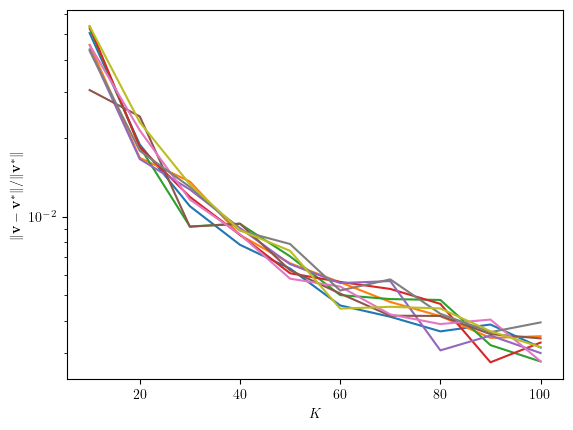

In [24]:
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)

# Load the two results with pickle and combine them
with open("opt_problems_K90.pickle", "rb") as handle:
    opt_problems_K90 = pickle.load(handle)

with open("opt_problems_K100.pickle", "rb") as handle:
    opt_problems_K100 = pickle.load(handle)

opt_problems = {**opt_problems_K90, **opt_problems_K100}


# Plot the results as K be the x-axis,  Max error of v_i as y-axis, and average over all N random settings of b and lmbda, (R,L) as different lines
K_values = list(np.linspace(10, 100, 10, dtype=int))
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]
combinations = itertools.product(K_values, R_values, L_values)

max_errors = np.zeros((len(K_values), len(R_values), len(L_values)))

N=10
for i, (K, R, L) in enumerate(combinations):
    errors = []
    for j in range(N):
        
          
        opt_problem_key = (i, j)
        A_theoretical = opt_problems[opt_problem_key].A[
                    0 : K]/opt_problems[opt_problem_key].A[K]
        errors.append(
            np.linalg.norm(opt_problems[opt_problem_key].v_i_value  - A_theoretical) / np.linalg.norm(A_theoretical)
            )
        
        max_errors[K_values.index(K),R_values.index(R),L_values.index(L)] = np.mean(errors)

fig, ax = plt.subplots()

for j, R in enumerate(R_values):
    for k, L in enumerate(L_values):
        ax.plot(K_values, max_errors[:, j, k], label=f"R={R}, L={L}")

ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$\|{\mathbf{v}- \mathbf{v}^*}\| / \| \mathbf{v}^* \|$")
ax.set_yscale("log")
# ax.legend()

plt.savefig("max_error_v_i.pdf", bbox_inches="tight")





In [17]:
np.linalg.norm(A_theoretical)

4.444807662845394

In [12]:
opt_problems[opt_problem_key].A[
                    0 : opt_problems[opt_problem_key].K]/opt_problems[opt_problem_key].A[opt_problems[opt_problem_key].K]

array([7.53762886e-04, 1.66604217e-03, 1.74282353e-03, 2.01635289e-03,
       3.26569051e-03, 4.82694176e-03, 6.12769606e-03, 6.56757120e-03,
       8.97320240e-03, 1.11147764e-02, 1.32558816e-02, 1.62428724e-02,
       1.87679056e-02, 2.13622216e-02, 2.54709271e-02, 2.86409385e-02,
       3.32610576e-02, 3.63019539e-02, 3.89751762e-02, 4.42827987e-02,
       4.95069391e-02, 5.44951831e-02, 5.82583225e-02, 5.93569501e-02,
       6.44868114e-02, 7.11948046e-02, 7.88116902e-02, 8.59439742e-02,
       9.17685746e-02, 9.84400502e-02, 1.04268671e-01, 1.12870046e-01,
       1.21663739e-01, 1.25604243e-01, 1.30455378e-01, 1.35242861e-01,
       1.38548084e-01, 1.43461451e-01, 1.54222016e-01, 1.61382821e-01,
       1.64694914e-01, 1.75583864e-01, 1.85050523e-01, 1.87695527e-01,
       1.99418166e-01, 2.10011864e-01, 2.15315746e-01, 2.21663078e-01,
       2.29727973e-01, 2.37110872e-01, 2.49670313e-01, 2.63578210e-01,
       2.74508982e-01, 2.84566427e-01, 2.95004002e-01, 3.10100911e-01,
      

In [10]:
opt_problems[opt_problem_key].v_i_value - opt_problems[opt_problem_key].A[
                    0 : opt_problems[opt_problem_key].K]

array([-9.99246176e-01, -2.20863297e+00, -2.31042704e+00, -2.67303962e+00,
       -4.32925605e+00, -6.39896856e+00, -8.12334458e+00, -8.70647483e+00,
       -1.18955631e+01, -1.47345938e+01, -1.75730019e+01, -2.15327834e+01,
       -2.48801548e+01, -2.83193718e+01, -3.37661869e+01, -3.79685889e+01,
       -4.40933736e+01, -4.81246053e+01, -5.16684162e+01, -5.87046089e+01,
       -6.56301286e+01, -7.22429205e+01, -7.72316064e+01, -7.86879949e+01,
       -8.54885209e+01, -9.43811552e+01, -1.04478693e+02, -1.13933795e+02,
       -1.21655310e+02, -1.30499514e+02, -1.38226352e+02, -1.49629006e+02,
       -1.61286610e+02, -1.66510382e+02, -1.72941361e+02, -1.79287958e+02,
       -1.83669538e+02, -1.90183010e+02, -2.04448074e+02, -2.13940934e+02,
       -2.18331580e+02, -2.32766834e+02, -2.45316548e+02, -2.48822828e+02,
       -2.64363296e+02, -2.78407113e+02, -2.85438222e+02, -2.93852622e+02,
       -3.04543988e+02, -3.14331227e+02, -3.30981028e+02, -3.49418484e+02,
       -3.63909129e+02, -